In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Rastgelelik seedi
import tensorflow as tf
tf.random.set_seed(2)

# Verinin yüklenmesi

In [3]:
current_dir = os.getcwd()
data_path = os.path.join(current_dir, "gaziemir.csv")
data = pd.read_csv(data_path)
data.head()

,date,pm25,pm10,o3,no2,so2,co
0,2025/1/1,115,50,18,,10,
1,2025/1/2,160,50,19,,10,
2,2025/1/3,140,32,19,,10,
3,2025/1/4,103,28,19,,9,
4,2025/1/5,94,37,7,,13,


In [4]:
# Eksik değer var mı?
data.isna().sum()

date     0
 pm25    0
 pm10    0
 o3      0
 no2     0
 so2     0
 co      0
dtype: int64

# Özelliklerin isimlerindeki boşlukların kaldırılması ve numeric hale çevirilmesi

In [5]:
data.columns = data.columns.str.strip()
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
for col in pollutants:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col].astype(str), errors='coerce')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629 entries, 0 to 3628
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3629 non-null   object 
 1   pm25    1177 non-null   float64
 2   pm10    3481 non-null   float64
 3   o3      756 non-null    float64
 4   no2     1467 non-null   float64
 5   so2     3449 non-null   float64
 6   co      1453 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.6+ KB


## Tarih sütununun datetime olarak belirlenmesi

In [7]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2025-01-01,115.0,50.0,18.0,NaN,10.0,NaN
2025-01-02,160.0,50.0,19.0,NaN,10.0,NaN
2025-01-03,140.0,32.0,19.0,NaN,10.0,NaN
2025-01-04,103.0,28.0,19.0,NaN,9.0,NaN
2025-01-05,94.0,37.0,7.0,NaN,13.0,NaN


### Verinin 2022-2025 arası filtrelenmesi

In [8]:
data = data.loc['2022-01-01':'2025-01-01']

In [9]:
# Tarihleri sıralayalım
data.sort_index(inplace=True)
data.head()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2022-01-01,143.0,62.0,NaN,46.0,8.0,18.0
2022-01-02,186.0,44.0,NaN,51.0,6.0,15.0
2022-01-03,134.0,52.0,NaN,47.0,6.0,15.0
2022-01-04,161.0,48.0,NaN,31.0,5.0,13.0
2022-01-05,154.0,30.0,NaN,24.0,4.0,10.0


In [10]:
# Eksik olan tarih veri noktalarını yaratalım
all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
missing_dates = all_dates.difference(data.index)
data = data.reindex(all_dates)

print("Eksik tarihler:")
print(missing_dates)

print(data.head())

Eksik tarihler:
DatetimeIndex(['2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23',
               '2023-11-17', '2023-11-18', '2023-11-19', '2024-02-08',
               '2024-03-17', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-04-16', '2024-06-15', '2024-06-20',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-06-29', '2024-06-30', '2024-07-09',
               '2024-07-11', '2024-07-12', '2024-07-15', '2024-08-14',
               '2024-09-21', '2024-11-06', '2024-11-23', '2024-11-24',
               '2024-12-30'],
              dtype='datetime64[ns]', freq=None)
             pm25  pm10  o3   no2  so2    co
2022-01-01  143.0  62.0 NaN  46.0  8.0  18.0
2022-01-02  186.0  44.0 NaN  51.0  6.0  15.0
2022-01-03  134.0  52.0 NaN  47.0  6.0  15.0
2022-01-04  161

In [11]:
# Her bir kirletici için eksik tarihler sonrası eksik veri miktarı
data.isna().sum()

pm25    191
pm10    107
o3      353
no2     240
so2     104
co      237
dtype: int64

In [12]:
# interpolate() ile eksik verileri dolduralım
data.interpolate(inplace=True)
print(data.isna().sum())

pm25      0
pm10      0
o3      213
no2       0
so2       0
co        0
dtype: int64


In [13]:
# Yine de o3 için eksik veri var. Belki de bu verinin en başlarında eksik veri bulunduğu için interpolate işe yaramadı.
# Backward fill ile dolduralım
data["o3"].fillna(method='bfill', inplace=True)
print(data.isna().sum())

pm25    0
pm10    0
o3      0
no2     0
so2     0
co      0
dtype: int64


## Aykırı değer analizi

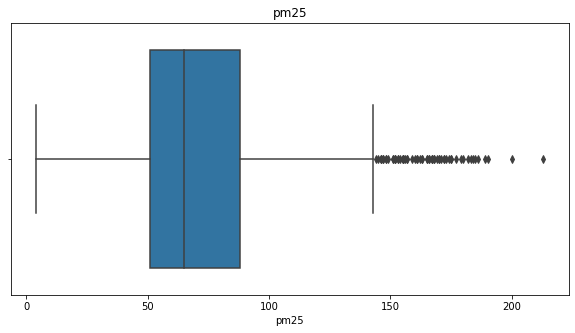

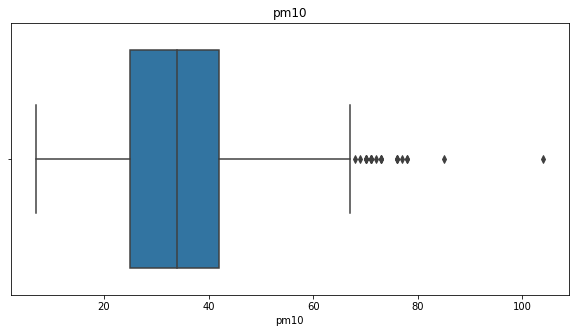

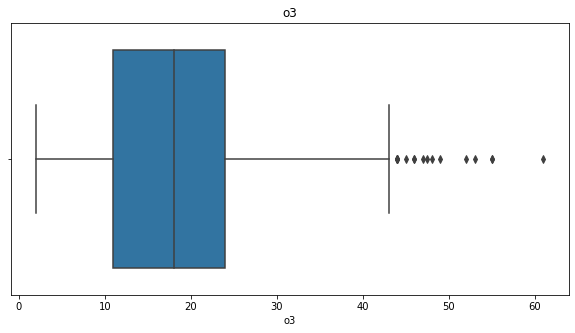

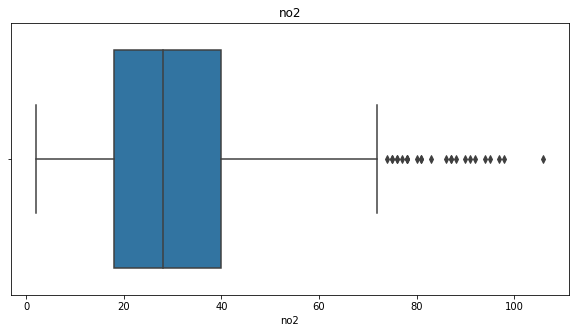

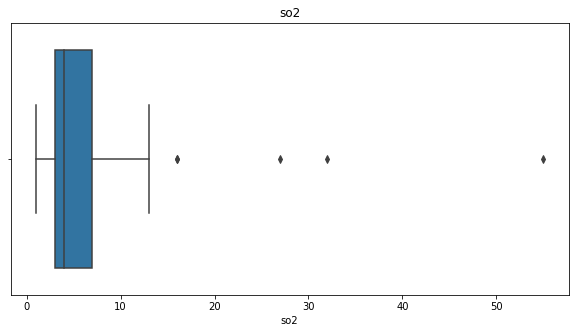

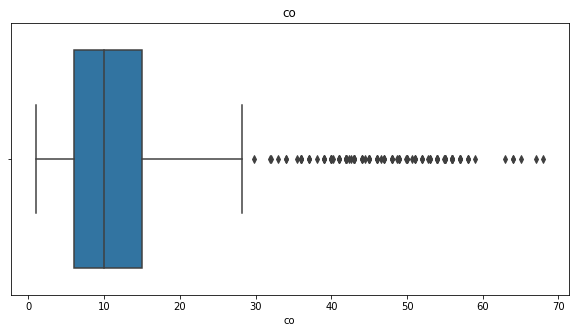

In [14]:
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
for i in pollutants:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x = data[i])
    plt.title(i)

In [15]:
# Aykırı değerleri çıkarmak yerine sınırlara kısıtlayalım.
def clamp_outliers(data, columns, lower_quantile=0.20, upper_quantile=0.80):
    for col in columns:
        lower_bound = data[col].quantile(lower_quantile)
        upper_bound = data[col].quantile(upper_quantile)
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    return data

data = clamp_outliers(data, pollutants)
data.head()

,pm25,pm10,o3,no2,so2,co
2022-01-01,96.0,45.0,18.0,42.0,7.0,17.0
2022-01-02,96.0,44.0,18.0,42.0,6.0,15.0
2022-01-03,96.0,45.0,18.0,42.0,6.0,15.0
2022-01-04,96.0,45.0,18.0,31.0,5.0,13.0
2022-01-05,96.0,30.0,18.0,24.0,4.0,10.0


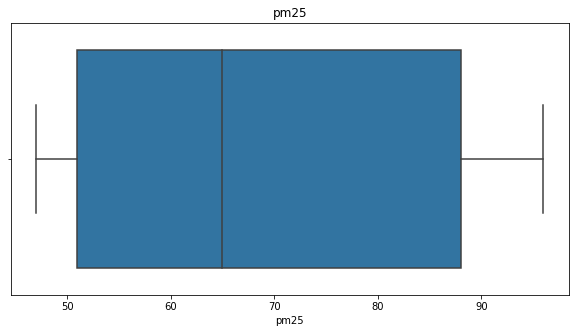

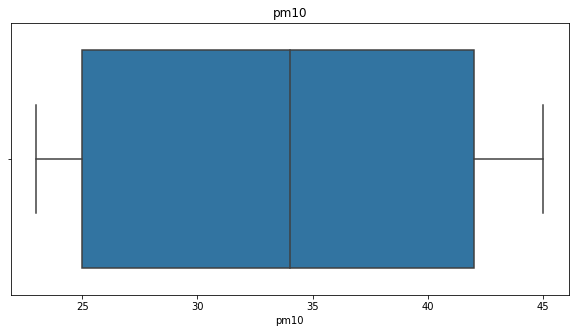

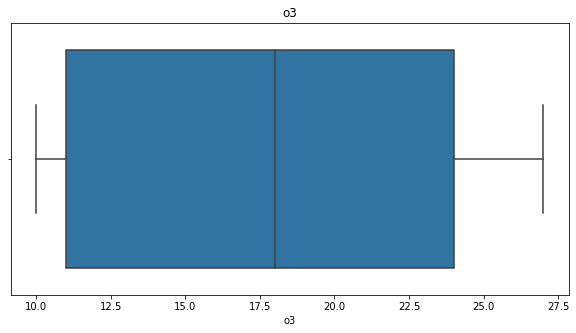

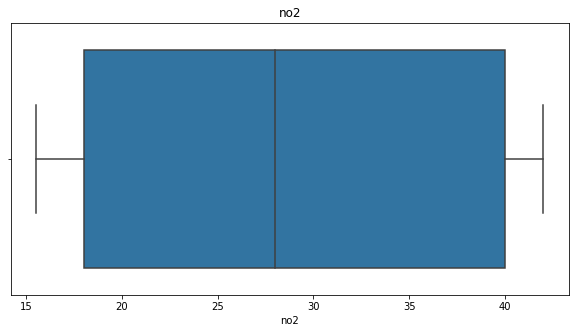

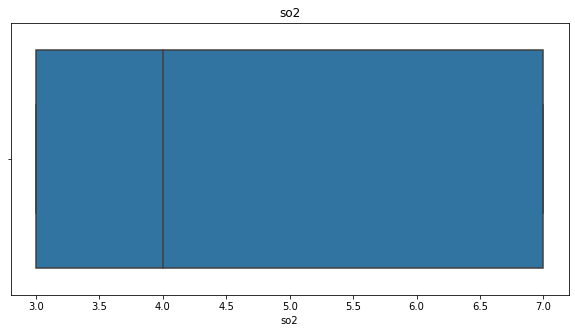

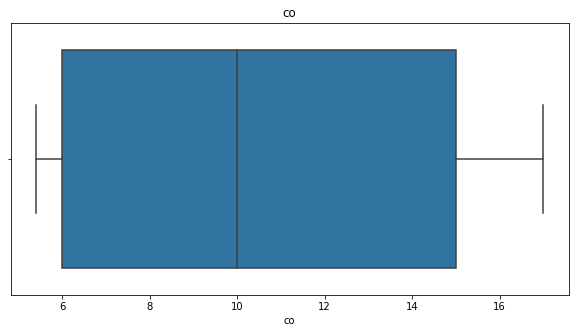

In [16]:
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
for i in pollutants:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x = data[i])
    plt.title(i)

In [17]:
data.drop(['co'], axis=1, inplace=True)

In [18]:
# Her bir satırdaki kirleticinin AQI değerini hesaplayıp, en yüksek AQI değerini özellik olarak bulunduran fonksiyon.
def calculate_aqi(value, breakpoints):
    for (c_low, i_low), (c_high, i_high) in zip(breakpoints, breakpoints[1:]):
        if c_low <= value <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
    return 0  
def get_max_aqi(row, breakpoints):
    aqi_values = [calculate_aqi(row[col], breakpoints[col]) for col in breakpoints]
    return max(aqi_values)

breakpoints = {
    "pm25": [(0.0, 0), (12.0, 50), (35.4, 100), (55.4, 150), (150.4, 200), (250.4, 300), (350.4, 400), (500.4, 500)],
    "pm10": [(0, 0), (54, 50), (154, 100), (254, 150), (354, 200), (424, 300), (504, 400), (604, 500)],
    "o3": [(0, 0), (54, 50), (70, 100), (85, 150), (105, 200), (200, 300)],
    "no2": [(0, 0), (53, 50), (100, 100), (360, 150), (649, 200), (1249, 300)],
    "so2": [(0, 0), (35, 50), (75, 100), (185, 150), (304, 200), (604, 300)],
    #"co": [(0.0, 0), (4.4, 50), (9.4, 100), (12.4, 150), (15.4, 200), (30.4, 300)]
}

data["AQI"] = data.apply(lambda row: get_max_aqi(row, breakpoints), axis=1)

print(data)


            pm25       pm10    o3   no2  so2         AQI
2022-01-01  96.0  45.000000  18.0  42.0  7.0  171.368421
2022-01-02  96.0  44.000000  18.0  42.0  6.0  171.368421
2022-01-03  96.0  45.000000  18.0  42.0  6.0  171.368421
2022-01-04  96.0  45.000000  18.0  31.0  5.0  171.368421
2022-01-05  96.0  30.000000  18.0  24.0  4.0  171.368421
...          ...        ...   ...   ...  ...         ...
2024-12-28  76.0  23.000000  15.0  18.0  7.0  160.842105
2024-12-29  79.0  24.666667  14.0  18.0  7.0  162.421053
2024-12-30  91.0  27.333333  13.0  18.0  7.0  168.736842
2024-12-31  96.0  30.000000  12.0  18.0  7.0  171.368421
2025-01-01  96.0  45.000000  18.0  18.0  7.0  171.368421

[1097 rows x 6 columns]


In [19]:
# co kirleticisi aşırı fazla aykırı değerlere sahip olduğu için, bu kirleticiyi veri setinden çıkarıyoruz.
#data.drop(columns=['pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], inplace=True)
data.drop(columns=['pm25', 'pm10', 'o3', 'no2', 'so2'], inplace=True)
data.head()

,AQI
2022-01-01,171.368421
2022-01-02,171.368421
2022-01-03,171.368421
2022-01-04,171.368421
2022-01-05,171.368421


In [20]:
# Veri ölçeklendiricisinin tanımı ve veri setinin ölçeklendirilmesi
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
aqi_data = data.astype('float32')

In [21]:
# test ve eğitim setlerinin oluşturulması
TRAIN_SIZE = 0.80

train_size = int(len(aqi_data)*TRAIN_SIZE)
test_size = len(aqi_data) - train_size

train, test = aqi_data[0:train_size, :], aqi_data[train_size:len(aqi_data),:]
print("Gün sayilari (training set, test set) : " + str((len(train),len(test))))

Gün sayilari (training set, test set) : (877, 220)


In [22]:
# Veri setinin LSTM için uygun hale getirilmesi
def veri_yap(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [23]:
# Windows size ile verinin kaç gün aralıklara bakacağına karar veriyorsunuz ve bu hücreden değiştiriyorsunuz.

window_size = 21
train_X, train_Y = veri_yap(train, window_size)
test_X, test_Y = veri_yap(test, window_size)
print("Orijinal train veri şekli:")
print(train_X.shape)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("Yeni train veri şekli:")
print(train_X.shape)

Orijinal train veri şekli:
(855, 21)
Yeni train veri şekli:
(855, 1, 21)


# Model eğitimi

In [24]:
# Model parametreleri
def fit_model(train_X, train_Y, window_size):
    model = Sequential()
    
    model.add(Bidirectional(LSTM(1000, 
                return_sequences=True),input_shape = (1, window_size)))
    model.add(LSTM(500, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss = "huber_loss", 
                  optimizer = "Adam")
   
    model.fit(train_X, 
              train_Y, 
              epochs =75, 
              batch_size =96, 
              verbose = 1)
    
    return(model)

model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/75
9/9 [==============================] - 6s 231ms/step - loss: 0.0725
Epoch 2/75
9/9 [==============================] - 2s 231ms/step - loss: 0.0386
Epoch 3/75
9/9 [==============================] - 2s 225ms/step - loss: 0.0304
Epoch 4/75
9/9 [==============================] - 2s 214ms/step - loss: 0.0294
Epoch 5/75
9/9 [==============================] - 2s 214ms/step - loss: 0.0256
Epoch 6/75
9/9 [==============================] - 2s 214ms/step - loss: 0.0244
Epoch 7/75
9/9 [==============================] - 2s 222ms/step - loss: 0.0230
Epoch 8/75
9/9 [==============================] - 2s 212ms/step - loss: 0.0222
Epoch 9/75
9/9 [==============================] - 2s 213ms/step - loss: 0.0216
Epoch 10/75
9/9 [==============================] - 2s 213ms/step - loss: 0.0217
Epoch 11/75
9/9 [==============================] - 2s 215ms/step - loss: 0.0217
Epoch 12/75
9/9 [==============================] - 2s 214ms/step - loss: 0.0214
Epoch 13/75
9/9 [==============================] 

In [25]:
# Değerlendirme metrikleri.
def tahminveskor(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform(Y.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(orig_data, pred[:, 0]))
    mae = mean_absolute_error(orig_data, pred[:, 0])
    r2 = r2_score(orig_data, pred[:, 0])
    mape = np.mean(np.abs((orig_data - pred[:, 0]) / orig_data)) * 100

    return rmse, mae, r2, mape, pred
rmse_train, mae_train, r2_train, mape_train, train_pred = tahminveskor(model1, train_X, train_Y)
rmse_test, mae_test, r2_test, mape_test, test_pred = tahminveskor(model1, test_X, test_Y)

print("Training data metrics:")
print("RMSE: %.2f, MAE: %.2f, R2: %.2f, MAPE: %.2f%%" % (rmse_train, mae_train, r2_train, mape_train))

print("Test data metrics:")
print("RMSE: %.2f, MAE: %.2f, R2: %.2f, MAPE: %.2f%%" % (rmse_test, mae_test, r2_test, mape_test))


7/7 [==============================] - 0s 14ms/step
Training data metrics:
RMSE: 8.45, MAE: 5.85, R2: 0.69, MAPE: 11.04%
Test data metrics:
RMSE: 5.93, MAE: 4.21, R2: 0.81, MAPE: 8.77%


7/7 [==============================] - 0s 14ms/step


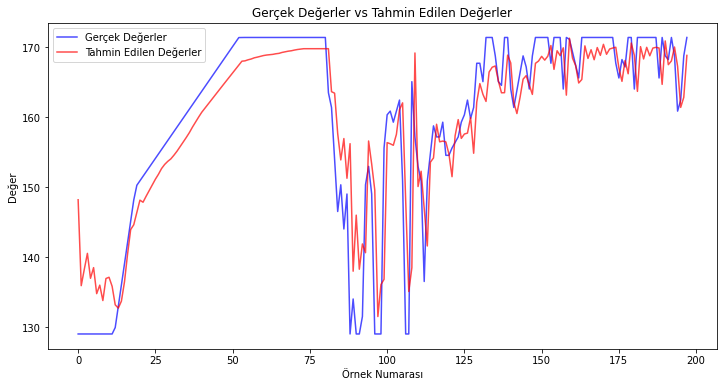

In [26]:
test_pred = scaler.inverse_transform(model1.predict(test_X))
orig_test_data = scaler.inverse_transform(test_Y.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(orig_test_data, label="Gerçek Değerler", color="blue", alpha=0.7)
plt.plot(test_pred, label="Tahmin Edilen Değerler", color="red", alpha=0.7)
plt.title("Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Örnek Numarası")
plt.ylabel("Değer")
plt.legend()
plt.show()